# Spectral Energy in directed Human Brain Connectome

In [20]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_surf
from src import operations
from src import graph_utils
from src import jordanzero_destroy

import h5py
import nibabel as nib
from scipy.io import loadmat

import scienceplots
plt.style.use(['science','ieee', 'no-latex'])

# for better visualisation of graphs. Comment out if not needed
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [3, 2]

## Description

GOAL: Analyse spectral energy in HCP task fMRI and rest fMRI

## Table of Contents
- [Graph Spectral Energy](#phase-profile)

In [5]:
resource_path = '../resources/'
data_path = '/Users/mikichan/Desktop/mywork/atlas_data/'

## Graph Spectral energy

#### Loading Graph and Transform

In [16]:
package = utils.load(utils.op.join(resource_path, 'brain_directed_graph/bin_directed_connectome_ftract+structural-d50+metadata.pkl'))
A, roi_atlas, region_labels = package['struct'], package['atlas'], package['regionnames']

nb_nodes = A.shape[0]

# A = operations.normalize_adjacency(A)
L, U, V, Uinv, _, _, _ = graph_utils.prep_transform(A, gso="adj")

Method chosen is: eig


#### Preparing Motor and Rest fMRI

In [51]:
labels = ['task-cues', 'left-foot', 'right-foot', 'left-hand', 'right-hand', 'tongue']

In [46]:
# LOAD DATA - MOTOR TASK
TR = 0.72
# list_subjects = ['100307', '100408', '101107', '101309', '101915']
list_subjects = ['100408', '101107', '101309']
# list_subjects = ['100408']
taskparadigms1 = []
taskparadigms2 = []

for subject in list_subjects:
    taskparadigms1.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_LR.mat'))['Regressor'][0])
    taskparadigms2.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_RL.mat'))['Regressor'][0])
taskparadigms1 = np.concatenate(taskparadigms1)
taskparadigms2 = np.concatenate(taskparadigms2)
ntimepoints = taskparadigms1.shape[-1]

print(f"Number of timepoints = {ntimepoints}")

# HCP task data - atlasing
motor1_roi_timecourses = []
motor2_roi_timecourses = []
atlas_data, affine = roi_atlas.get_fdata(), roi_atlas.affine
for subject in tqdm(list_subjects):
    subpath2volumes = f'HCP_sample/HCP_motor/volume/{subject}/'
    file_list1 =  os.listdir(op.join(data_path, subpath2volumes, 'tfMRI_MOTOR_LR/fMRIvols_GLMyes'))
    reorder_list1 = np.argsort([int(file[-8:-4]) for file in file_list1 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list1 = np.array(file_list1)[reorder_list1]
    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'tfMRI_MOTOR_LR/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list1])
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s

    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)
    motor1_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1))

    file_list2 =  os.listdir(op.join(data_path, subpath2volumes, 'tfMRI_MOTOR_RL/fMRIvols_GLMyes'))
    reorder_list2 = np.argsort([int(file[-8:-4]) for file in file_list2 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list2 = np.array(file_list2)[reorder_list2]

    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'tfMRI_MOTOR_RL/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list2])
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s
    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)
    motor2_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1))
    
motor1_roi_timecourses = np.concatenate(motor1_roi_timecourses, axis=1)
motor2_roi_timecourses = np.concatenate(motor2_roi_timecourses, axis=1)

# LOAD DATA - REST
# list_subjects = ['100307', '100408', '101107', '101309', '101915']

# HCP task data - atlasing
rest1_roi_timecourses = []
rest2_roi_timecourses = []
max_timepoints = 250
for subject in tqdm(list_subjects):
    subpath2volumes = f'HCP_sample/HCP_rest/volume/{subject}/'
    file_list1 =  os.listdir(op.join(data_path, subpath2volumes, 'rfMRI_REST1_LR/fMRIvols_GLMyes'))
    reorder_list1 = np.argsort([int(file[-8:-4]) for file in file_list1 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list1 = np.array(file_list1)[reorder_list1]
    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'rfMRI_REST1_LR/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list1])
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s
    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)

    rest1_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1)[:, :motor1_roi_timecourses.shape[1] // 3])
    
    file_list2 =  os.listdir(op.join(data_path, subpath2volumes, 'rfMRI_REST1_RL/fMRIvols_GLMyes'))
    reorder_list2 = np.argsort([int(file[-8:-4]) for file in file_list2 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list2 = np.array(file_list2)[reorder_list2]

    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'rfMRI_REST1_RL/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list2])
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s    

    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)

    # Resize rest to match same length as in motor
    rest2_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1)[:, :motor1_roi_timecourses.shape[1] // 3])
    
rest1_roi_timecourses = np.concatenate(rest1_roi_timecourses, axis=1)
rest2_roi_timecourses = np.concatenate(rest2_roi_timecourses, axis=1)

Number of timepoints = 852


100%|██████████| 3/3 [02:54<00:00, 58.18s/it]


#### Results

In [63]:
graph_fourier_mtimecourse1 = np.array([operations.GFT(motor1_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])
graph_fourier_mtimecourse2 = np.array([operations.GFT(motor2_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])
graph_fourier_mtimecourse1 = graph_fourier_mtimecourse1[taskparadigms1 != 0]
graph_fourier_mtimecourse2 = graph_fourier_mtimecourse2[taskparadigms2 != 0]

graph_fourier_rtimecourse1 = np.array([operations.GFT(rest1_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])
graph_fourier_rtimecourse2 = np.array([operations.GFT(rest2_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])

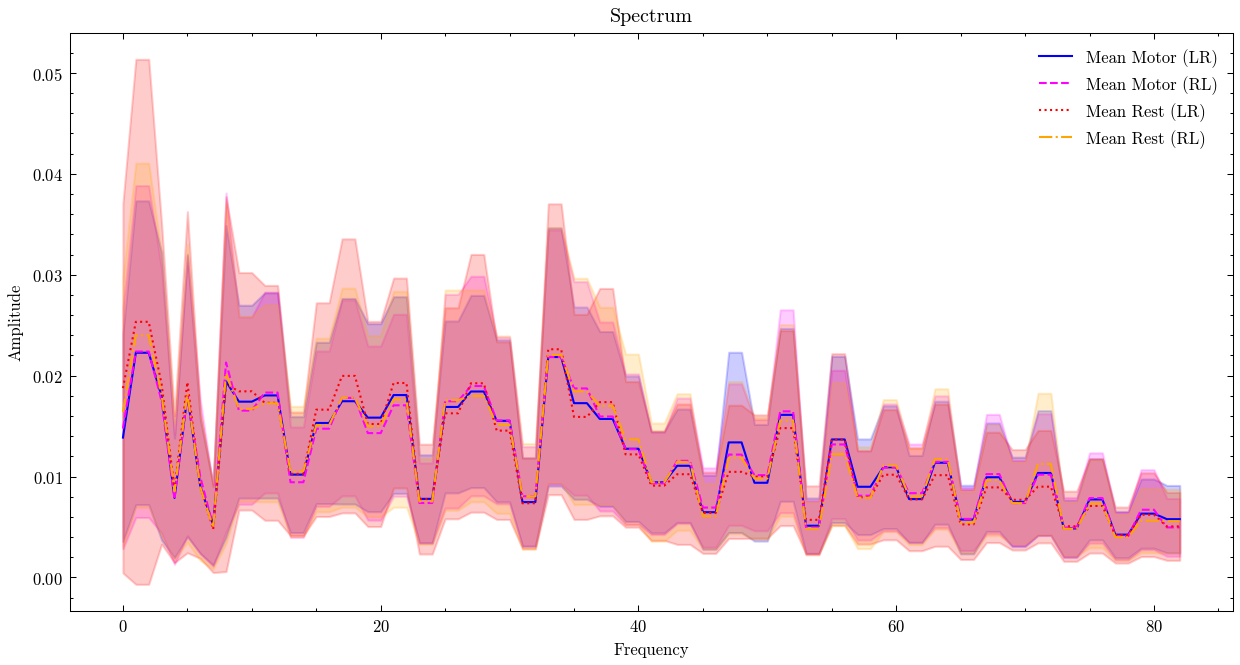

In [64]:
mean_gft1 = np.mean(np.abs(graph_fourier_mtimecourse1), axis=0)
std_gft1 = np.std(np.abs(graph_fourier_mtimecourse1), axis=0) / mean_gft1.sum()
mean_gft1 /= mean_gft1.sum()
mean_gft2 = np.mean(np.abs(graph_fourier_mtimecourse2), axis=0)
std_gft2 = np.std(np.abs(graph_fourier_mtimecourse2), axis=0) / mean_gft2.sum()
mean_gft2 /= mean_gft2.sum()

mean_gft1_r = np.mean(np.abs(graph_fourier_rtimecourse1), axis=0)
std_gft1_r = np.std(np.abs(graph_fourier_rtimecourse1), axis=0) / mean_gft1_r.sum()
mean_gft1_r /= mean_gft1_r.sum()

mean_gft2_r = np.mean(np.abs(graph_fourier_rtimecourse2), axis=0)
std_gft2_r = np.std(np.abs(graph_fourier_rtimecourse2), axis=0) / mean_gft2_r.sum()
mean_gft2_r /= mean_gft2_r.sum()

plt.figure(figsize=(10, 5))
plt.plot(mean_gft1, label='Mean Motor (LR)', color='b')
plt.fill_between(range(len(mean_gft1)), mean_gft1 - std_gft1, mean_gft1 + std_gft1, color='b', alpha=0.2)
plt.plot(mean_gft2, label='Mean Motor (RL)', color='magenta')
plt.fill_between(range(len(mean_gft2)), mean_gft2 - std_gft2, mean_gft2 + std_gft2, color='magenta', alpha=0.2)

plt.plot(mean_gft1_r, label='Mean Rest (LR)', color='r')
plt.fill_between(range(len(mean_gft1_r)), mean_gft1_r - std_gft1_r, mean_gft1_r + std_gft1_r, color='r', alpha=0.2)
plt.plot(mean_gft2_r, label='Mean Rest (RL)', color='orange')
plt.fill_between(range(len(mean_gft2)), mean_gft2_r - std_gft2_r, mean_gft2_r + std_gft2_r, color='orange', alpha=0.2)

plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Spectrum')
plt.legend()
plt.show()

In [66]:
from collections import Counter
Counter(taskparadigms1)

Counter({0: 371, 3: 96, 1: 96, 5: 96, 2: 96, 4: 97})

Visualize brain frequencies and phase shift to see where are oscillations 


In [194]:
with open('../../atlas_data/lausanne2008/lausanne2008_33-extra_data/bounding_boxes.txt') as f:
    tmp = f.readlines()[1:]
    coords = []
    for o in tmp:
        splits = o.strip().split(',')
        coords.append([np.mean([float(splits[0]), float(splits[1])]), 
                       np.mean([float(splits[2]), float(splits[3])]),
                               np.mean([float(splits[4]), float(splits[5])])])
    coords = np.array(coords)

with open('../../atlas_data/lausanne2008/lausanne2008_33-extra_data/region_labels.txt') as f:
    other_order_regions = f.readlines()
    other_order_regions = [o.strip().lower() for o in other_order_regions]

hatethis_img = nib.load('../../atlas_data/lausanne2008/lausanne2008_33-extra_data/region_masks.nii')

In [220]:
# Resampling the stupid image that is not in the sampling size of what I get from f-tract lausanne2008
# How can this be made so poorly so little thought was put into this?, I hate this so much
from nilearn.image import resample_img

affine, shape = roi_atlas.affine, roi_atlas.get_fdata().shape
print("Resampling the second image (this takes time)...")
resampled = resample_img(
    hatethis_img, affine, shape[:3], force_resample=True
)

# Rematching again the orders, how comes people can't agree on a single order? it's the exact same
# MAP THE LABELS TO THE SAME ORDER!

from difflib import SequenceMatcher

def get_best_match(label, other_labels):
    best_match = None
    highest_ratio = 0
    for other_label in other_labels:
        ratio = SequenceMatcher(None, label, other_label).ratio()
        if ratio > highest_ratio:
            highest_ratio = ratio
            best_match = other_label
    return best_match

matched_labels = {label: get_best_match(label, other_order_regions) for label in region_labels}
original_indexes = np.array([other_order_regions.index(matched_labels[label]) for label in matched_labels.keys()])

coords = np.array([np.array(np.where(resampled.get_fdata()==k+1)).mean(axis=1) for k in range(nb_nodes)])
reordered_coords = np.array(coords)[original_indexes]

Resampling the second image (this takes time)...


In [426]:
from joblib import Parallel, delayed

def volcoord2mnicoord(arrays: np.ndarray, affine: np.ndarray):
    """
    Compute volume coordinates to MNI coordinates transform.

    Transforms a set of 3D volume coordinates to MNI coordinates using 
    a provided affine transform matrix. The affine matrix maps between 
    volume voxel indices and MNI coordinates.

    Parameters
    ----------
    arrays : np.ndarray
        The volume coordinate arrays to transform. Each coordinate is a row.
    affine : np.ndarray 
        The affine transform matrix mapping volume to MNI coordinates.

    Returns
    -------
    ret : np.ndarray
        The MNI coordinates corresponding to the input volume coordinates.
    """

    tmp = np.concatenate([arrays, np.ones((arrays.shape[0], 1))], axis=1)
    ret = np.matmul(affine, tmp.T)[:3].T

    return np.array(ret).astype(float)

def mnicoord2volcoord(arrays: np.ndarray, affine: np.ndarray):
    """
    Compute volume coordinates from MNI coordinates.

    Transforms MNI coordinates to equivalent volume coordinates using
    the provided affine transform.

    Parameters
    ----------
    arrays : np.ndarray
        Array of MNI coordinates to transform.
    affine : np.ndarray
        Affine transform mapping from MNI space to volume space.

    Returns
    -------
    np.ndarray
        Array of transformed volume coordinates.
    """

    inv_affine = np.linalg.inv(affine)
    tmp = np.concatenate([arrays, np.ones((arrays.shape[0], 1))], axis=1)
    ret = np.matmul(inv_affine, tmp.T)[:3].T

    return np.array(ret).astype(int)

def visualize_braingraph(signal, A, coords, figsize=(5, 5), axview=(0, 0), 
                         phasegrain=12, cmap="bwr", nscale=100, hlv=0.85, nsizelegend=None):
    """
    Visualizing braingraphs and associated signals in MNI
    """
    slocation = deepcopy(coords)
    
    assert np.sum(np.abs(signal - signal.mean())) != 0, "Signal mut not be constant"
    nodes = {"x": [], "y": [], "z": [], "signal": [], "phase": []}
    edges = {"i": [], "j": [], "weight": []}

    grain = np.linspace(0, np.pi, phasegrain)
    p = plt.get_cmap(cmap)
    # populate nodes
    for sidx, s in enumerate(slocation):
        nodes["x"].append(s[0])
        nodes["y"].append(s[1])
        nodes["z"].append(s[2])

        angleencode = np.where((np.angle(signal[sidx]) - grain) <= 0)[0][0]
        nodes["phase"].append(p(angleencode / (phasegrain - 1)))
        # nodes["signal"].append(np.abs(scaled_signal[sidx]))
        nodes["signal"].append(np.abs(signal[sidx]))

    nodes = pd.DataFrame.from_dict(nodes)

    # populate edges
    for idx, s1 in enumerate(slocation):
        for jdx, s2 in enumerate(slocation):
            if idx > jdx:
                continue
            if A[idx, jdx] != 0:
                edges["i"].append(idx)
                edges["j"].append(jdx)
                edges["weight"].append(A[idx, jdx] / 50)

    edges = pd.DataFrame.from_dict(edges)

    if nsizelegend is None:
        nsizelegend = [np.round(np.min(nodes["signal"]), 2), np.round(np.max(nodes["signal"]),2)]

    fig, ax = netplotbrain.plot(
        template="MNI152NLin2009cAsym",
        templatestyle="glass",
        nodes=nodes,
        node_size='signal',
        node_color="phase",
        edges=edges,
        #   highlight_edges = adj,
        node_scale=nscale,
        # node_sizevminvmax=nodevminvmax,
        highlight_level=hlv,
        node_sizelegend=nsizelegend,
    )
    ax[0].view_init(elev=axview[1], azim=axview[0])
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    return fig, ax[0]

def visualize_braingraph_dynamic(signals, A, coords, figsize=(5, 5), axview=(0, 0), 
                         phasegrain=12, cmap="bwr", nscale=100, hlv=0.85):
    """
    Visualizing braingraphs and associated signals in MNI
    """
    nsizelegend = [np.round(np.abs(signals).min(),2), np.round(np.abs(signals).max(),2)]
    def save_braingraph(k):
        fig, ax = visualize_braingraph(signals[k], A, coords, figsize=figsize, axview=axview, 
                                       phasegrain=phasegrain, cmap=cmap, nscale=nscale, hlv=hlv, nsizelegend=nsizelegend)
        fig.savefig(f'../figure_resources/braingraph_{k}.png')
        plt.close(fig)

    Parallel(n_jobs=-1)(delayed(save_braingraph)(k) for k in tqdm(range(len(signals))))

In [427]:
harmonic_idx = 1
phases_shifted = np.array([operations.apply_phaseshift(ps, U[:, harmonic_idx].real, U, V, Uinv=Uinv) 
                           for ps in np.linspace(0, 2*np.pi, 100)])

(<Figure size 750x750 with 3 Axes>, <Axes3D: title={'center': 'Left'}>)

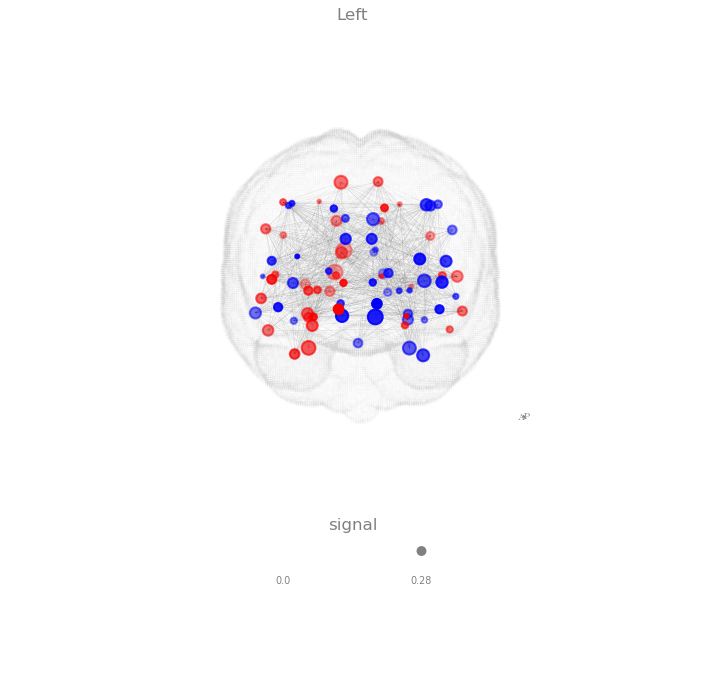

In [443]:
visualize_braingraph(phases_shifted[1].real, A, volcoord2mnicoord(reordered_coords, affine), 
                     figsize=(5, 5), axview=(90, 0), nscale=50)

In [447]:
visualize_braingraph_dynamic(phases_shifted.real, A, volcoord2mnicoord(reordered_coords, affine), figsize=(5, 5), axview=(90, 0))

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


In [448]:
import cv2

f'./figure_resources/braingraph_{k}.png'
image_folder = '../figure_resources/'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
video_name = op.join(image_folder, 'tmp.mp4')
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

!ffmpeg -i ../figure_resources/tmp.mp4 ../figure_resources/braingraph_video_harmonic_1_view2.mp4 -y

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-libspeex

In [1]:
from ipywidgets import Output, GridspecLayout
from IPython import display

filepaths = ['../figure_resources/braingraph_video.mp4', '../figure_resources/braingraph_video_harmonic_1.mp4',
             '../figure_resources/braingraph_video_harmonic_1_view2.mp4', '../figure_resources/braingraph_video_harmonic_1.mp4']
grid = GridspecLayout(2, len(filepaths))

for i, filepath in enumerate(filepaths):
    r,c = i // 2, i % 2
    out = Output()
    with out:
        # display.display(display.Video(filepath, embed=True))
        display.display(display.Video(filepath, embed=True, html_attributes="controls loop autoplay"))
    grid[r, c] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…